In [1]:
import pandas
dfAll = pandas.read_csv("okcupid_profiles.csv")
dfAll.shape
dfAll.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


In [2]:
dfAll = dfAll.query( "height >= 24")
dfAll = dfAll.query( "income >= 0")
dfAll.describe()

,age,height,income
count,11502.000000,11502.000000,11502.000000
mean,32.468179,69.114589,104319.248826
std,9.747387,3.913451,201277.724419
min,18.000000,26.000000,20000.000000
25%,25.000000,67.000000,20000.000000
50%,30.000000,69.000000,50000.000000
75%,37.000000,72.000000,100000.000000
max,69.000000,95.000000,1000000.000000


In [3]:
df = dfAll.sample(n=6000)
df.shape

(6000, 31)

In [4]:
df.isna().sum()

age               0
status            0
sex               0
orientation       0
body_type       308
diet           2137
drinks          114
drugs           933
education       378
ethnicity       396
height            0
income            0
job             176
last_online       0
location          0
offspring      3079
pets           1452
religion       1276
sign            724
smokes          274
speaks            3
essay0          441
essay1          647
essay2          819
essay3          984
essay4         1004
essay5         1040
essay6         1207
essay7         1072
essay8         1614
essay9         1049
dtype: int64

In [5]:
df = df.dropna( subset=["essay0"] )

In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ahern\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['sentiment'] = [sia.polarity_scores(x)['compound'] for x in df['essay0']]

In [8]:
import numpy
rng = numpy.random.RandomState( 28 )
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( df, df.age, random_state=rng, test_size=0.5 )

In [9]:
lstNum = [ 'height', 'income', 'sentiment' ]
lstCat = [ 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'job', 'offspring', 'pets', 'religion', 'sign', 'smokes']

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
pipeNum = Pipeline( [
    ("selector", ColumnTransformer([ ("selector", "passthrough", lstNum ) ] )),
    ('scaler', StandardScaler() )
    ])
from sklearn.preprocessing import OneHotEncoder
pipeCat = Pipeline([
    ('selector', ColumnTransformer([ ("selector", "passthrough", lstCat ) ] )),
    ('encoder', OneHotEncoder( dtype=int, drop="first", handle_unknown='ignore' ) )
    ])

In [12]:
from sklearn.pipeline import FeatureUnion
preprocessorBase = FeatureUnion([
    ('cat', pipeCat ),
    ('num', pipeNum )
    ])

In [13]:
from xgboost import XGBRegressor
pipeBase = Pipeline([
    ('preprocessor', preprocessorBase ),
    ('model', XGBRegressor() )
    ])

In [14]:
pipeBase.fit( X_train, y_train )
import sklearn.metrics
predTestBase = pipeBase.predict( X_test )
sklearn.metrics.r2_score( y_test, predTestBase )

C:\Users\Ahern\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 7, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.34689206957183727

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

pipeTextLda = Pipeline([
    ('selector', ColumnTransformer([ ("selector",
    CountVectorizer( max_features=1000, stop_words="english" ),
    'essay0' ) ] ) ),
    ('topic', LatentDirichletAllocation( n_components=10 ) ),
    ])
preprocessorLda = FeatureUnion([
    ('cat', pipeCat ),
    ('text', pipeTextLda ),
    ('num', pipeNum )
    ])
pipeLda = Pipeline([
    ('preprocessor', preprocessorLda ),
    ('model', XGBRegressor() )
    ])

In [18]:
pipeLda.fit( X_train, y_train )
predTestLda = pipeLda.predict( X_test )
sklearn.metrics.r2_score( y_test, predTestLda )

C:\Users\Ahern\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 7, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.3596034188475902

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

pipeTextNmf = Pipeline([
    ('selector', ColumnTransformer([ ("selector",
    TfidfVectorizer( max_features=1000, stop_words="english" ),
    'essay0' ) ] ) ),
    ('topic', NMF( n_components=10, max_iter=2000 ) ),
    ])
preprocessorNmf = FeatureUnion([
    ('cat', pipeCat ),
    ('text', pipeTextNmf ),
    ('num', pipeNum )
    ])
pipeNmf = Pipeline([
    ('preprocessor', preprocessorNmf ),
    ('model', XGBRegressor() )
    ])

In [22]:
pipeNmf.fit( X_train, y_train )
predTestNmf = pipeNmf.predict( X_test )
sklearn.metrics.r2_score( y_test, predTestNmf )

C:\Users\Ahern\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 7, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.35192563076676375

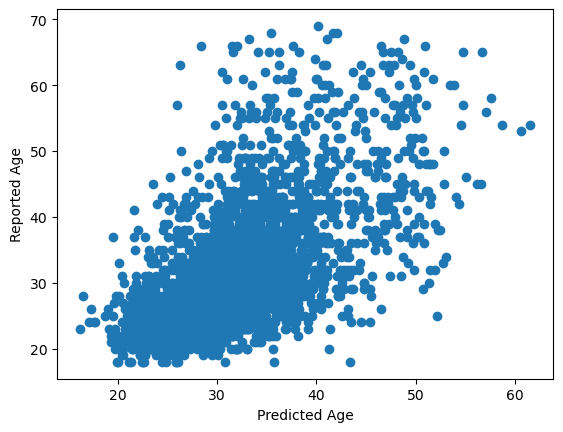

In [24]:
import matplotlib.pyplot
scatter = matplotlib.pyplot.scatter(predTestNmf, y_test )
matplotlib.pyplot.xlabel('Predicted Age')
matplotlib.pyplot.ylabel('Reported Age')
matplotlib.pyplot.show()

In [ ]:
### PART II

In [25]:
import pandas
df = pandas.read_csv( "DJIA_table.csv", parse_dates=["MarketDate"] )
df.dtypes

MarketDate    datetime64[ns]
movement              object
Close                float64
nextClose            float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

Text(0, 0.5, 'Closing DJIA')

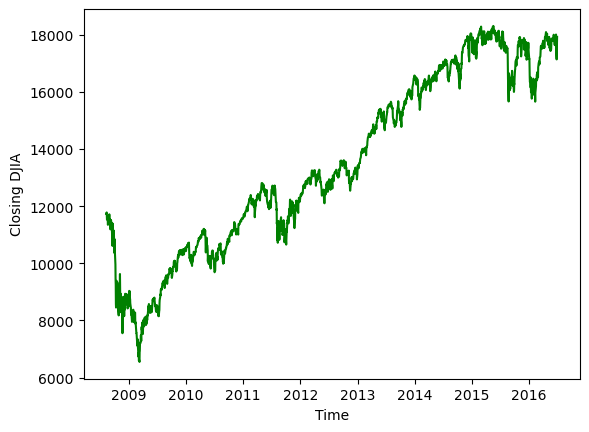

In [27]:
import matplotlib.pyplot
matplotlib.pyplot.plot( df.MarketDate, df.Close, color = 'green', label = 'DJIA')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.ylabel('Closing DJIA')

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit( df[ ["Close"] ] )
df[ "CloseScaled" ] = sc.transform( df[ ["Close"] ] )

In [29]:
lagdays = 60
lenTrain = 1500
X_train = []
y_train = []
for i in range( lagdays, lenTrain ):
    X_train.append( df.loc[ i-lagdays:i, "CloseScaled"] )
    y_train.append( df.loc[ i, "CloseScaled" ] )

In [30]:
import numpy
X_train = numpy.array(X_train)
y_train = numpy.array(y_train)
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [32]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
numUnits = 50
model = Sequential()
model.add( LSTM(units=numUnits,return_sequences=True,input_shape=(X_train.shape[1], 1)) )
model.add( Dropout(0.2) )
model.add( LSTM(units=numUnits) )
model.add( Dropout(0.2) )
model.add( Dense(units=1) )
model.compile( loss='mean_squared_error' )

In [33]:
numEpochs = 100 # make yours small, maybe 10, in class
modelLstm = model.fit(X_train,y_train,epochs=numEpochs )

Epoch 1/100
45/45 [==============================] - 7s 41ms/step - loss: 0.0647
Epoch 2/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0188
Epoch 3/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0166
Epoch 4/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0150
Epoch 5/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0128
Epoch 6/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0132
Epoch 7/100
45/45 [==============================] - 2s 37ms/step - loss: 0.0109
Epoch 8/100
45/45 [==============================] - 2s 36ms/step - loss: 0.0110
Epoch 9/100
45/45 [==============================] - 2s 36ms/step - loss: 0.0111
Epoch 10/100
45/45 [==============================] - 2s 35ms/step - loss: 0.0098
Epoch 11/100
45/45 [==============================] - 2s 36ms/step - loss: 0.0096
Epoch 12/100
45/45 [==============================] - 2s 36ms/step - loss: 0.0105
Epoch 13/100
45/45 [=====

Text(0.5, 0, 'epoch')

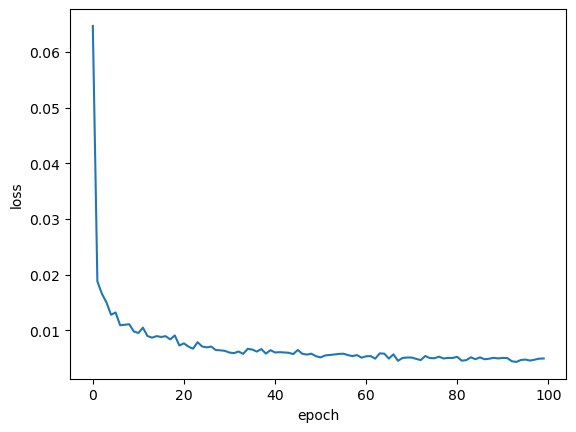

In [34]:
matplotlib.pyplot.plot( modelLstm.history['loss'] )
matplotlib.pyplot.ylabel('loss')
matplotlib.pyplot.xlabel('epoch')

In [58]:
import numpy
X_test = []
for i in range( lagdays, len(df)):
    X_test.append( df.loc[ i-lagdays:i, "CloseScaled" ] )
    X_test = numpy.array(X_test)
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [38]:
df[ "predictedScaled" ] = numpy.NaN
df.loc[ lagdays:len(df), "predictedScaled" ] = model.predict(X_test)
df[ "predicted" ] = sc.inverse_transform( df[ [ "predictedScaled" ] ] )

1/1 [==============================] - 1s 1s/step


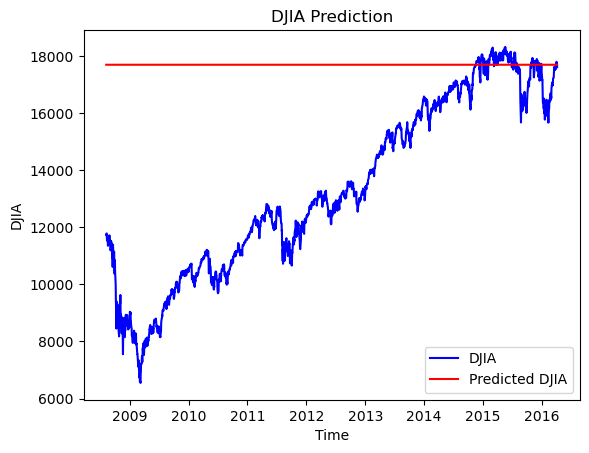

In [53]:
dfPlot = df[ lagdays+1:]
matplotlib.pyplot.plot( dfPlot.MarketDate, dfPlot.Close,
color = 'blue', label = 'DJIA')
matplotlib.pyplot.plot( dfPlot.MarketDate, dfPlot.predicted, color = 'red', label = 'Predicted DJIA')
matplotlib.pyplot.title('DJIA Prediction')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.ylabel('DJIA')
matplotlib.pyplot.legend()